In [1]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, KNNWithMeans, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/merged_df.csv')
#use cols userId, wine, rating
data = data[['userId', 'wine', 'rate']]
data.head()

,userId,wine,rate
0,826c6abe-7147-4b69-aaea-275fe65b033a,Cavalcaonte Barbera Forlí,5
1,d838a526-4b0a-4fad-b54f-90b6ca321fca,Shiraz,2
2,d838a526-4b0a-4fad-b54f-90b6ca321fca,Pinot Noir,3
3,bec96c0b-5b0b-4992-8756-e0d3b704afb5,Timorasso,5
4,bec96c0b-5b0b-4992-8756-e0d3b704afb5,Le Difese,4


In [2]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','Metric','Optimizer','User_based',
             'RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, Metric, Optimizer, User_based, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [3]:
class KnnWithMeans (KNNWithMeans):
    def __init__(self, sim_options={}, bsl_options = {}):
        KNNWithMeans.__init__(self, sim_options=sim_options, bsl_options= bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)
        
    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            KNNWithMeans.fit(self, trainset_fold)
            train_prediction = KNNWithMeans.test(self, trainset_fold.build_testset())
            prediction = KNNWithMeans.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = KNNWithMeans.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        '''Return the k nearest neighbors of user_id'''
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        '''Return the k nearest neighbors of item_id'''
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## KnnWithMeans SGD

* knn_with_means cosine, user based

In [4]:
knn_with_means = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means.create_reader(data)
predictions = knn_with_means.fit()
#acc
metrics = knn_with_means.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2546
RMSE: 0.8837
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2547
RMSE: 0.9645
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2595
RMSE: 0.8845
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2770
RMSE: 0.9057
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2223
RMSE: 0.9728
###############################################
The Results are: 

Average RMSE on Training Set: 0.253633334389498
Average RMSE on Test Set: 0.9222354172125821
RMSE: 0.8709
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8708719056365072
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.8709
MAE:  0.7006
MSE: 0.7584
Precision: 0.67
Recall: 0.70
the acc is 43.56


/tmp/ipykernel_18195/655597585.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_means cosine, item based

In [5]:
knn_with_means2 = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means2.create_reader(data)
predictions = knn_with_means2.fit()
#acc
metrics = knn_with_means2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2738
RMSE: 0.9077
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3045
RMSE: 0.9075
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2679
RMSE: 1.0175
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3051
RMSE: 0.9816
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2892
RMSE: 0.8954
###############################################
The Results are: 

Average RMSE on Training Set: 0.28808850522811114
Average RMSE on Test Set: 0.9419239879241103
RMSE: 0.8731
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8731041781382435
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.8731
MAE:  0.7138
MSE: 0.7623
Precision: 0.56
Recall: 0.60
the acc is 39.60


/tmp/ipykernel_18195/3877873262.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18195/3877873262.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans mean squared difference, user based

In [6]:
knn_with_means3 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means3.create_reader(data)
predictions = knn_with_means3.fit()
#acc
metrics = knn_with_means3.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 3
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2059
RMSE: 0.8158
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2088
RMSE: 0.9189
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1891
RMSE: 0.9545
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1787
RMSE: 0.9244
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1908
RMSE: 0.8831
###############################################
The Results are: 

Average RMSE on Training Set: 0.19465439254067388
Average RMSE on Test Set: 0.8993533906441746
RMSE: 0.9963
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.996347805395527
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.9963
MAE:  0.7979
MSE: 0.9927
Precision: 0.63
Recall: 0.67
the acc is 38.12


/tmp/ipykernel_18195/289524525.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18195/289524525.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans mean squared diference, item based

In [7]:
knn_with_means4 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means4.create_reader(data)
predictions = knn_with_means4.fit()
#acc
metrics = knn_with_means4.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 4
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2461
RMSE: 0.9056
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2354
RMSE: 0.8255
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2271
RMSE: 0.8723
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2182
RMSE: 0.9391
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2272
RMSE: 0.9695
###############################################
The Results are: 

Average RMSE on Training Set: 0.23080074029718722
Average RMSE on Test Set: 0.9023852598331803
RMSE: 0.9771
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9771311079046912
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.9771
MAE:  0.7998
MSE: 0.9548
Precision: 0.63
Recall: 0.68
the acc is 36.14


/tmp/ipykernel_18195/2026458134.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18195/2026458134.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson, user based

In [8]:
knn_with_means5 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means5.create_reader(data)
predictions = knn_with_means5.fit()
#acc
metrics = knn_with_means5.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 5
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1809
RMSE: 0.8352
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1418
RMSE: 0.9844
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1825
RMSE: 0.9415
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1340
RMSE: 0.9063
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1706
RMSE: 0.9416
###############################################
The Results are: 

Average RMSE on Training Set: 0.16195435986487877
Average RMSE on Test Set: 0.9218078101997016
RMSE: 0.9069
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9068783091535534
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.9069
MAE:  0.7222
MSE: 0.8224
Precision: 0.65
Recall: 0.70
the acc is 42.57


/tmp/ipykernel_18195/2000926961.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18195/2000926961.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson, item based

In [9]:
knn_with_means6 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means6.create_reader(data)
predictions = knn_with_means6.fit()
#acc
metrics = knn_with_means6.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 6
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1781
RMSE: 0.8581
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1666
RMSE: 0.9452
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1693
RMSE: 0.9993
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1571
RMSE: 0.9884
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1876
RMSE: 0.8886
###############################################
The Results are: 

Average RMSE on Training Set: 0.17172845082516855
Average RMSE on Test Set: 0.9359122314753998
RMSE: 0.8873
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8873484837924841
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.8873
MAE:  0.7177
MSE: 0.7874
Precision: 0.63
Recall: 0.67
the acc is 45.05


/tmp/ipykernel_18195/1753961335.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18195/1753961335.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, user based

In [10]:
knn_with_means7 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means7.create_reader(data)
predictions = knn_with_means7.fit()
#acc
metrics = knn_with_means7.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 7
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1118
RMSE: 0.9165
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1573
RMSE: 0.8666
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1651
RMSE: 0.8228
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.0980
RMSE: 0.9442
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1625
RMSE: 0.9953
###############################################
The Results are: 

Average RMSE on Training Set: 0.1389441859195046
Average RMSE on Test Set: 0.9090953002681232
RMSE: 0.9502
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9501716932614942
Computing the pearson_baseline similarity matrix.

/tmp/ipykernel_18195/101808052.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18195/101808052.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, item based

In [11]:
knn_with_means8 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means8.create_reader(data)
predictions = knn_with_means8.fit()
#acc
metrics = knn_with_means8.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 8
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1095
RMSE: 0.8901
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1549
RMSE: 0.8252
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1336
RMSE: 0.9654
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1470
RMSE: 0.9178
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1093
RMSE: 1.0362
###############################################
The Results are: 

Average RMSE on Training Set: 0.1308620379324157
Average RMSE on Test Set: 0.9269566519042703
RMSE: 1.0270
RMSE on Test Set on UNSEEN DATA is RMSE, : 1.0270071515641375
Computing the pearson_baseline similarity matrix.

/tmp/ipykernel_18195/1437423512.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18195/1437423512.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


## KnnWithMeans Alternating Least Squares (ALS)

* KnnWithMeans cosine, user based

In [12]:
knn_with_means9 = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means9.create_reader(data)
predictions = knn_with_means9.fit()
#acc
metrics = knn_with_means9.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 9
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2525
RMSE: 0.9612
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2303
RMSE: 0.8710
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2275
RMSE: 0.9367
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2456
RMSE: 0.8819
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2609
RMSE: 0.8894
###############################################
The Results are: 

Average RMSE on Training Set: 0.24336288401556722
Average RMSE on Test Set: 0.908046636571035
RMSE: 0.9012
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9011515297048928
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9012
MAE:  0.7261
MSE: 0.8121
Precision: 0.64
Recall: 0.71
the acc is 42.08


/tmp/ipykernel_18195/1812438443.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18195/1812438443.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans cosine, item based

In [13]:
knn_with_means10 = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means10.create_reader(data)
predictions = knn_with_means10.fit()
#acc
metrics = knn_with_means10.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 10
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2412
RMSE: 0.8942
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2519
RMSE: 0.8702
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2578
RMSE: 0.8382
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2617
RMSE: 0.9087
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2390
RMSE: 0.9517
###############################################
The Results are: 

Average RMSE on Training Set: 0.25032593164551276
Average RMSE on Test Set: 0.8925966471676932
RMSE: 0.9743
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.974343535605534
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9743
MAE:  0.7678
MSE: 0.9493
Precision: 0.66
Recall: 0.69
the acc is 45.54


/tmp/ipykernel_18195/3298270025.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18195/3298270025.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeansWithMeansWithMeans mean squared difference, user based

In [14]:
knn_with_means11 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means11.create_reader(data)
predictions = knn_with_means11.fit()
#acc
metrics = knn_with_means11.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 11
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2164
RMSE: 0.9739
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2430
RMSE: 0.8700
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2330
RMSE: 0.8674
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1867
RMSE: 1.0260
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2384
RMSE: 0.8738
###############################################
The Results are: 

Average RMSE on Training Set: 0.2234828693955754
Average RMSE on Test Set: 0.9222155754889784
RMSE: 0.8674
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8674323850359642
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.8674
MAE:  0.7000
MSE: 0.7524
Precision: 0.62
Recall: 0.65
the acc is 49.01


/tmp/ipykernel_18195/4069916643.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18195/4069916643.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeansWithMeans mean squared difference, item based

In [15]:
knn_with_means12 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means12.create_reader(data)
predictions = knn_with_means12.fit()
#acc
metrics = knn_with_means12.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 12
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2328
RMSE: 0.8373
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2530
RMSE: 0.8996
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2097
RMSE: 1.0724
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2401
RMSE: 0.8971
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2358
RMSE: 0.9733
###############################################
The Results are: 

Average RMSE on Training Set: 0.23428956284487562
Average RMSE on Test Set: 0.9359612493473705
RMSE: 0.9118
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9118402451184084
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9118
MAE:  0.7163
MSE: 0.8315
Precision: 0.65
Recall: 0.68
the acc is 45.05


/tmp/ipykernel_18195/3923251051.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18195/3923251051.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson correlation coefficient, user based

In [16]:
knn_with_means13 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means13.create_reader(data)
predictions = knn_with_means13.fit()
#acc
metrics = knn_with_means13.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 13
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1306
RMSE: 0.9078
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1704
RMSE: 0.8385
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1156
RMSE: 0.9332
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1874
RMSE: 0.8917
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1824
RMSE: 0.9811
###############################################
The Results are: 

Average RMSE on Training Set: 0.15729973053458973
Average RMSE on Test Set: 0.9104645884752408
RMSE: 0.8736
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8736489679430253
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.8736
MAE:  0.7081
MSE: 0.7633
Precision: 0.63
Recall: 0.72
the acc is 42.57


/tmp/ipykernel_18195/3977358235.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18195/3977358235.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson correlation coefficient, item based

In [17]:
knn_with_means14 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means14.create_reader(data)
predictions = knn_with_means14.fit()
#acc
metrics = knn_with_means14.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 14
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1701
RMSE: 0.8779
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1522
RMSE: 0.9142
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1608
RMSE: 0.9420
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1160
RMSE: 0.9442
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1404
RMSE: 0.9686
###############################################
The Results are: 

Average RMSE on Training Set: 0.14791750061965733
Average RMSE on Test Set: 0.9293781290233646
RMSE: 0.9039
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9039420154005401
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.9039
MAE:  0.6881
MSE: 0.8171
Precision: 0.65
Recall: 0.70
the acc is 48.51


/tmp/ipykernel_18195/2985716342.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18195/2985716342.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, user based

In [18]:
knn_with_means15 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means15.create_reader(data)
predictions = knn_with_means15.fit()
#acc
metrics = knn_with_means15.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 15
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1421
RMSE: 0.8953
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1326
RMSE: 0.9935
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1559
RMSE: 0.8921
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1702
RMSE: 0.8992
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1429
RMSE: 0.9294
###############################################
The Results are: 

Average RMSE on Training Set: 0.14873814248201217
Average RMSE on Test Set: 0.9219068626320148
RMSE: 0.8820
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.8820133571971862
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_18195/1732976370.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18195/1732976370.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, item based

In [19]:
knn_with_means16 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means16.create_reader(data)
predictions = knn_with_means16.fit()
#acc
metrics = knn_with_means16.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 16
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1469
RMSE: 0.8949
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1442
RMSE: 0.8846
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1230
RMSE: 0.9041
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1495
RMSE: 0.9669
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1162
RMSE: 0.9239
###############################################
The Results are: 

Average RMSE on Training Set: 0.135971862200376
Average RMSE on Test Set: 0.9148836273493502
RMSE: 0.9996
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.9996159568844758
Computing the pearson_baseline similarity matrix..

/tmp/ipykernel_18195/3559677741.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_18195/3559677741.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [20]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,Metric,Optimizer,User_based,RMSE,MAE,MSE,Precision,Recall,Accuracy
10,11,KnnWithMeans,MSD,ALS,True,0.867432,0.700042,0.752439,0.620476,0.651944,49.009901
0,1,KnnWithMeans,Cosine,SGD,True,0.870872,0.700552,0.758418,0.666520,0.696730,43.564356
1,2,KnnWithMeans,Cosine,SGD,False,0.873104,0.713766,0.762311,0.558736,0.603622,39.603960
12,13,KnnWithMeans,pearson corr coeff,ALS,True,0.873649,0.708123,0.763263,0.632981,0.723097,42.574257
14,15,KnnWithMeans,(shrunk) pearson corr coeff,ALS,True,0.882013,0.726681,0.777948,0.643571,0.718767,44.554455
5,6,KnnWithMeans,pearson corr coeff,SGD,False,0.887348,0.717735,0.787387,0.628763,0.670605,45.049505
8,9,KnnWithMeans,Cosine,ALS,True,0.901152,0.726111,0.812074,0.642271,0.712077,42.079208
13,14,KnnWithMeans,pearson corr coeff,ALS,False,0.903942,0.688095,0.817111,0.652224,0.698223,48.514851
4,5,KnnWithMeans,pearson corr coeff,SGD,True,0.906878,0.722237,0.822428,0.652778,0.702249,42.574257
11,12,KnnWithMeans,MSD,ALS,False,0.911840,0.716273,0.831453,0.646065,0.676745,45.049505


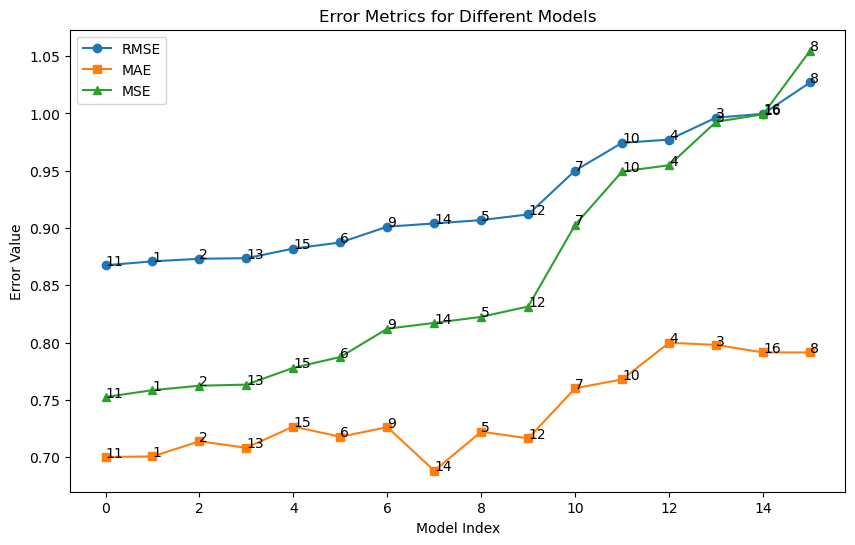

In [21]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

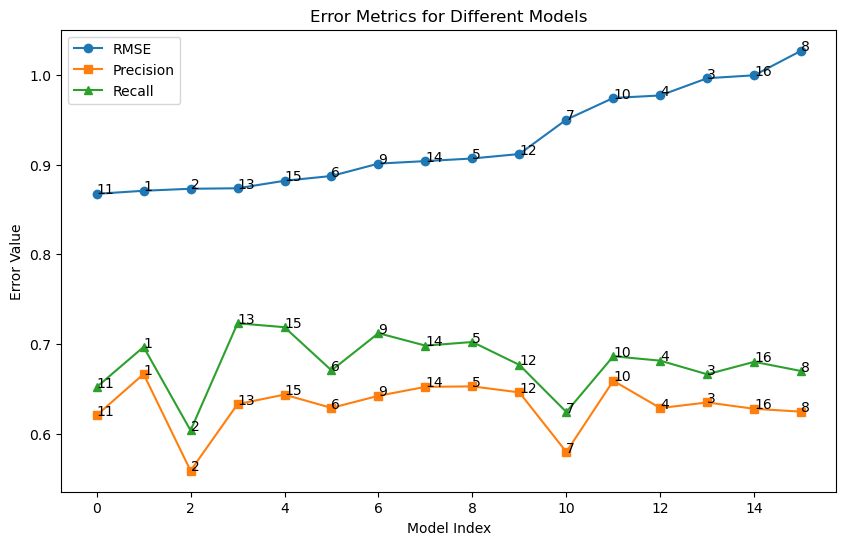

In [22]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

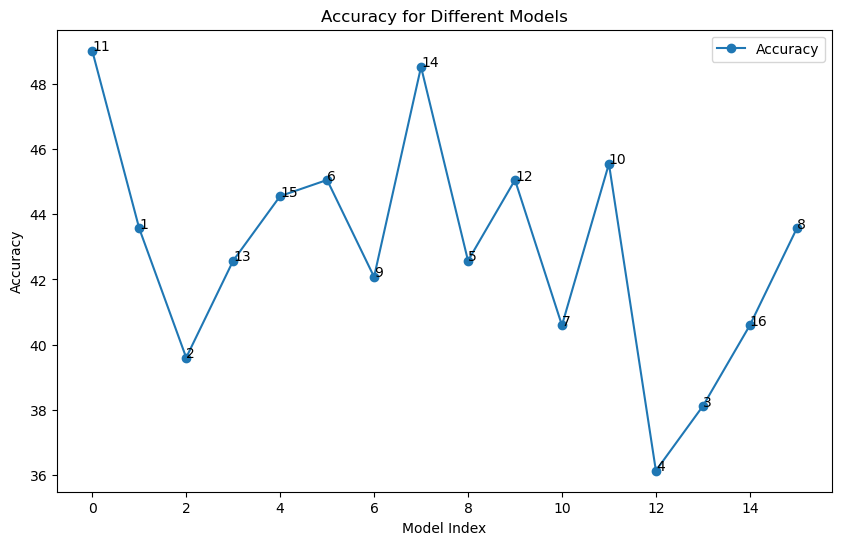

In [23]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [24]:
#recommends items for a given user from predictions

# user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
# top_n = KnnWithMeans.get_top_n_for_user(predictions, user_id)
# print(user_id, [iid for (iid, _) in top_n])
######### better print
user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
top_n = knn_with_means.get_top_n_for_user(predictions, user_id)
print(f"Top items for the user '{user_id}' are:")
for i, (iid, _) in enumerate(top_n, 1):
    print(f"{i}. Item ID: {iid}")

Top items for the user '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7' are:
1. Item ID: Cirus Madiran
2. Item ID: Pommard
3. Item ID: Pinot gris
4. Item ID: Clos la Laterne
5. Item ID: Les Pierrelles Crozes-Hermitage
6. Item ID: LFE900
7. Item ID: Yellow Label 
8. Item ID: Groot Constantia
9. Item ID: Le Grand Saumur


In [25]:
# recommneds users for a given item from predictions

# item_id = 'Chardonnay'
# top_n = KnnWithMeans.get_top_n_users_for_item(predictions, item_id)
# print(item_id, [uid for (uid, _) in top_n])
########## better print
item_id = 'Chardonnay'
top_n = knn_with_means.get_top_n_users_for_item(predictions, item_id)
print(f"Top users for the item '{item_id}' are:")
for i, (uid, _) in enumerate(top_n, 1):
    print(f"{i}. User ID: {uid}")

Top users for the item 'Chardonnay' are:
1. User ID: 9c85a219-a94e-4b78-b300-ea65e52e9c6e
2. User ID: 5ccd8030-047b-432c-a630-d784ab415756


In [26]:
#get the KnnWithMeans for a user from the model
knn_with_means.get_neighbors_uid(user_id=5)

['5ccd8030-047b-432c-a630-d784ab415756',
 '36fec3ea-e183-491d-b65a-6c7ac90fafa5',
 'ecc462e1-5041-43ca-94c3-c2bfc9b3215e',
 '2a62eecd-b0cd-4395-9f8c-7c912a208be2',
 'd7fffb49-a1f3-433c-a556-a3bc015e7e0f',
 '73923070-fce4-46c0-8d85-a99527e73d02',
 '9250d444-805f-4756-a03b-93a597ab320d',
 '406ed450-5225-41ac-a02f-3ac1d1a1179b',
 'f8c400a6-ded1-40b8-95d2-a263d05c30ce',
 '9a3cc655-c88e-4c1b-95e2-add7579ff4c2']

In [27]:
#get the KnnWithMeans for an item from the model
knn_with_means.get_neighbors_iid(item_id=20)

['Sauvignon de la Tour',
 'Refosco ',
 'Cuvée Rot',
 'No Land Vineyard',
 'Cabernet Sauvignon (Reserva)',
 'Cabernet Franc',
 'The long coast cabernet sauvignon',
 'Weissburgunder Trocken',
 'Frescaripa Bardolino Classico',
 'Rose']

In [28]:
knn_with_means.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(knn_with_means.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 12 with sim 0.000000000000000
And the baseline estimate is: 3.6364714577537276

#####

Note: If the baseline is 3.609302325581395 then the value is a default value, Otherwise not


In [29]:
df_pred = knn_with_means.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,918cd9b7-8057-4106-8f7f-9e9e3a423fb1,Albariño,4.0,3.627907,"{'was_impossible': True, 'reason': 'User and/o...",3,1,0.372093
1,0a23a07a-8556-4ef6-85ee-d996f8ed619e,Talò Primitivo - Merlot,4.0,3.627907,"{'was_impossible': True, 'reason': 'User and/o...",1,1,0.372093
2,5ccd8030-047b-432c-a630-d784ab415756,Limoux,3.0,3.627907,"{'was_impossible': True, 'reason': 'User and/o...",64,0,0.627907
3,826c6abe-7147-4b69-aaea-275fe65b033a,Cavalcaonte Barbera Forlí,5.0,3.627907,"{'was_impossible': True, 'reason': 'User and/o...",0,0,1.372093
4,bc79b0e3-064d-4240-86de-e86499f577e8,Paul Jaboulet Aine,3.0,3.627907,"{'was_impossible': True, 'reason': 'User and/o...",42,1,0.627907
5,457b85f5-7b46-4f52-85b9-59acb549b9a2,Elevation Sauvignon Blanc,4.0,3.627907,"{'was_impossible': True, 'reason': 'User and/o...",3,0,0.372093
6,91cf68cc-9436-43e1-871d-33beef4d2337,Beppe Marino Barbera d'Asti Superiore DOCG,3.0,3.627907,"{'was_impossible': True, 'reason': 'User and/o...",19,1,0.627907
7,df904a46-c461-4233-9d44-6ac11a8bbddc,Orvieto classico amabile,3.0,3.627907,"{'was_impossible': True, 'reason': 'User and/o...",7,0,0.627907
8,a8cc530e-e3fe-4a50-a043-a376ea599bf2,Nespolino Rubicone Sangiovese - Merlot,4.0,3.627907,"{'was_impossible': True, 'reason': 'User and/o...",1,1,0.372093
9,bec96c0b-5b0b-4992-8756-e0d3b704afb5,Aspromonte,5.0,3.627907,"{'was_impossible': True, 'reason': 'User and/o...",3,1,1.372093


* best predictions

In [30]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
63,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Lagrein Riserva,4.0,4.0,"{'actual_k': 9, 'was_impossible': False}",104,0,0.0
197,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Baron amarillo rioja denomacion de origen cali...,4.0,4.0,"{'actual_k': 1, 'was_impossible': False}",31,2,0.0
196,5ccd8030-047b-432c-a630-d784ab415756,Randersacker Spätburgunder Rosé,3.0,3.0,"{'actual_k': 1, 'was_impossible': False}",64,1,0.0
70,bc79b0e3-064d-4240-86de-e86499f577e8,Terroir de Granit Saint Joseph,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",42,1,0.0
78,defee34b-7775-4889-b703-92b730d85e70,Malvasia,4.0,4.0,"{'actual_k': 0, 'was_impossible': False}",6,4,0.0
151,76b71bb0-6cc9-4168-8a45-bbafc1e9a256,Sauvignon,4.0,4.0,"{'actual_k': 0, 'was_impossible': False}",8,3,0.0
48,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Il Mattaglio Blanc de Noirs,5.0,5.0,"{'actual_k': 9, 'was_impossible': False}",104,1,0.0
98,9a3cc655-c88e-4c1b-95e2-add7579ff4c2,Omega Rosso,3.0,3.0,"{'actual_k': 0, 'was_impossible': False}",6,2,0.0
154,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Pinot Bianco,3.0,3.0,"{'actual_k': 1, 'was_impossible': False}",55,2,0.0
61,2ae69fac-d491-412f-8164-ccaf59a230c2,Ronco del Balbo Merlot,5.0,5.0,"{'actual_k': 5, 'was_impossible': False}",6,3,0.0


* worst predictions

In [31]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
174,918cd9b7-8057-4106-8f7f-9e9e3a423fb1,Cabernet Sauvignon,3.0,5.000000,"{'actual_k': 1, 'was_impossible': False}",3,4,2.000000
199,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Cabernet Franc,2.0,4.000000,"{'actual_k': 1, 'was_impossible': False}",19,6,2.000000
110,36fec3ea-e183-491d-b65a-6c7ac90fafa5,Merlot,2.0,4.200000,"{'actual_k': 0, 'was_impossible': False}",55,5,2.200000
137,4c0b31a0-1287-4efc-b24c-fe850084eafd,Chianti,5.0,2.666667,"{'actual_k': 0, 'was_impossible': False}",2,5,2.333333
27,bc79b0e3-064d-4240-86de-e86499f577e8,3／4 大亂鬥 11,1.0,3.627907,"{'was_impossible': True, 'reason': 'User and/o...",42,0,2.627907
163,20e0b694-84a5-4f11-9191-598f924c2947,Morellino di Scansano 2021,1.0,3.627907,"{'was_impossible': True, 'reason': 'User and/o...",1,1,2.627907
105,eadb1fb9-7260-4618-aa5a-8f2ebdca2077,Bread & Butter Pinor Noir 2020,1.0,3.627907,"{'was_impossible': True, 'reason': 'User and/o...",1,0,2.627907
125,bc79b0e3-064d-4240-86de-e86499f577e8,3／4 大亂鬥 6,1.0,3.627907,"{'was_impossible': True, 'reason': 'User and/o...",42,1,2.627907
118,4ed273f7-1816-4f36-88c7-789125f011c7,Moscato d'Asti,1.0,3.627907,"{'was_impossible': True, 'reason': 'User and/o...",3,2,2.627907
198,bc79b0e3-064d-4240-86de-e86499f577e8,2/5 大亂鬥 2,1.0,3.627907,"{'was_impossible': True, 'reason': 'User and/o...",42,1,2.627907
